In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("simulated_pharmacy_data.csv", parse_dates=["date", "expiry_date"])

In [4]:
df.head()

,date,medicine_name,category,quantity_sold,stock_on_hand,price_per_unit,expiry_date
0,2023-07-01,Paracetamol,Painkiller,18,982,2.0,2024-06-11
1,2023-07-01,Ibuprofen,Painkiller,20,980,3.0,2025-01-30
2,2023-07-01,Amoxicillin,Antibiotic,10,990,5.0,2025-01-30
3,2023-07-01,Cetirizine,Antihistamine,22,978,1.5,2024-08-21
4,2023-07-01,Azithromycin,Antibiotic,15,985,6.0,2024-08-17


In [5]:
para_df = df[df["medicine_name"] == "Paracetamol"]
monthly_sales = para_df.groupby(df["date"].dt.to_period("M"))["quantity_sold"].sum().reset_index()
monthly_sales["date"] = monthly_sales["date"].dt.to_timestamp()
prophet_df = monthly_sales.rename(columns={"date": "ds", "quantity_sold": "y"})

In [6]:
model = Prophet()
model.fit(prophet_df)


01:35:27 - cmdstanpy - INFO - Chain [1] start processing
01:35:28 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\anshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


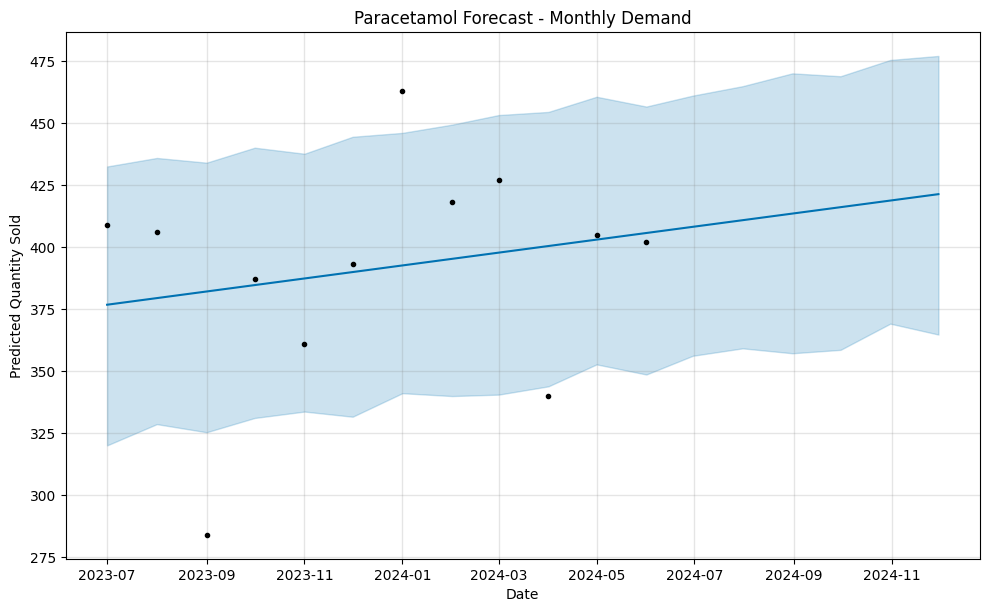

In [7]:
future = model.make_future_dataframe(periods=6, freq="M")  # forecast next 6 months
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Paracetamol Forecast - Monthly Demand")
plt.xlabel("Date")
plt.ylabel("Predicted Quantity Sold")
plt.show()


In [8]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(6)


,ds,yhat,yhat_lower,yhat_upper
12,2024-06-30,408.194017,356.192075,461.108424
13,2024-07-31,410.862360,359.181630,464.906703
14,2024-08-31,413.530702,357.197580,470.081515
15,2024-09-30,416.112969,358.571956,468.915371
16,2024-10-31,418.781312,369.139923,475.481348
17,2024-11-30,421.363579,364.740608,477.100759


C:\Users\anshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


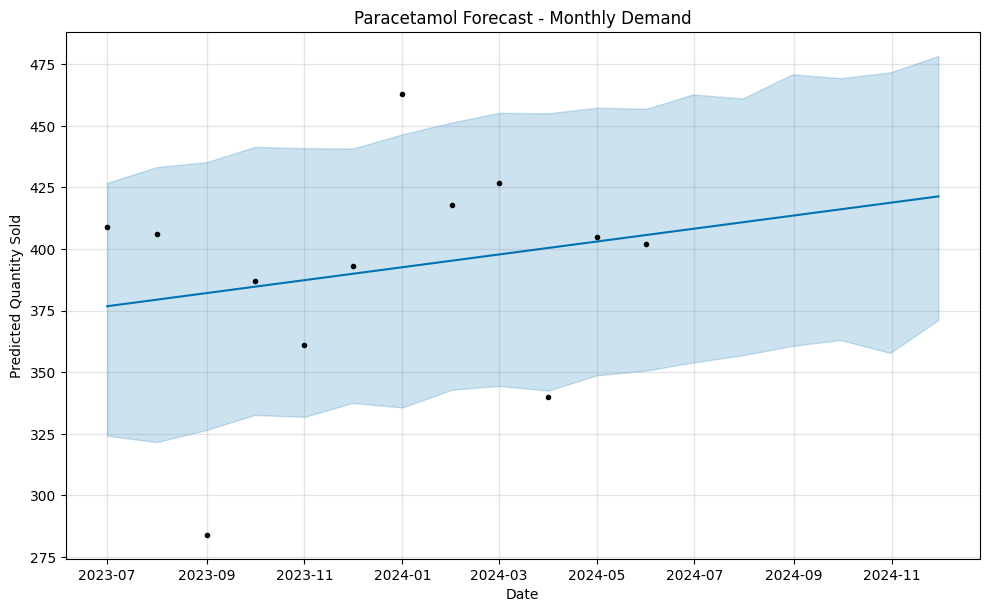

In [9]:
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)
model.plot(forecast)
plt.title("Paracetamol Forecast - Monthly Demand")
plt.xlabel("Date")
plt.ylabel("Predicted Quantity Sold")
plt.grid(True)
plt.show()


In [10]:
latest_stock = df[df["medicine_name"] == "Paracetamol"].sort_values("date").iloc[-1]["stock_on_hand"]
print("Latest Stock Available:", latest_stock)


Latest Stock Available: 992


In [11]:
future_forecast = forecast[forecast["ds"] > df["date"].max()][["ds", "yhat"]].copy()
future_forecast["predicted_demand"] = future_forecast["yhat"].round().astype(int)
future_forecast["available_stock"] = latest_stock
future_forecast["shortage_risk"] = future_forecast["predicted_demand"] > latest_stock
future_forecast[["ds", "predicted_demand", "available_stock", "shortage_risk"]]

,ds,predicted_demand,available_stock,shortage_risk
13,2024-07-31,411,992,False
14,2024-08-31,414,992,False
15,2024-09-30,416,992,False
16,2024-10-31,419,992,False
17,2024-11-30,421,992,False


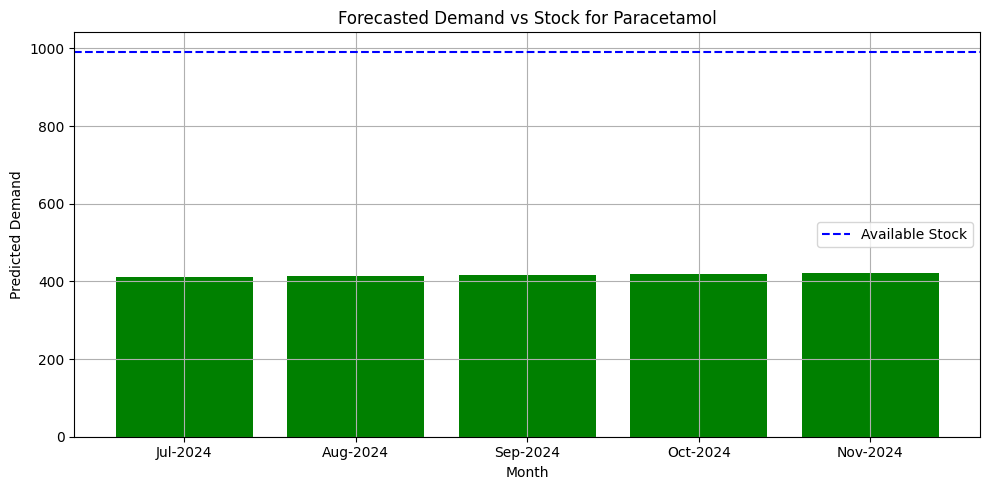

In [16]:
colors = ['red' if risk else 'green' for risk in future_forecast['shortage_risk']]

plt.figure(figsize=(10, 5))
plt.bar(future_forecast['ds'].dt.strftime('%b-%Y'), future_forecast['predicted_demand'], color=colors)
plt.axhline(latest_stock, color='blue', linestyle='--', label='Available Stock')
plt.title("Forecasted Demand vs Stock for Paracetamol")
plt.xlabel("Month")
plt.ylabel("Predicted Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
stock = latest_stock
reorder_plan = []
for _, row in future_forecast.iterrows():
    demand = row["predicted_demand"]
    shortage = max(demand - stock, 0)
    reorder = shortage
    stock = max(stock - demand, 0) + reorder
    reorder_plan.append(reorder)

future_forecast["reorder_quantity"] = reorder_plan


In [21]:
future_forecast[["ds", "predicted_demand", "available_stock", "reorder_quantity"]]


,ds,predicted_demand,available_stock,reorder_quantity
13,2024-07-31,411,200,0
14,2024-08-31,414,200,0
15,2024-09-30,416,200,249
16,2024-10-31,419,200,170
17,2024-11-30,421,200,251


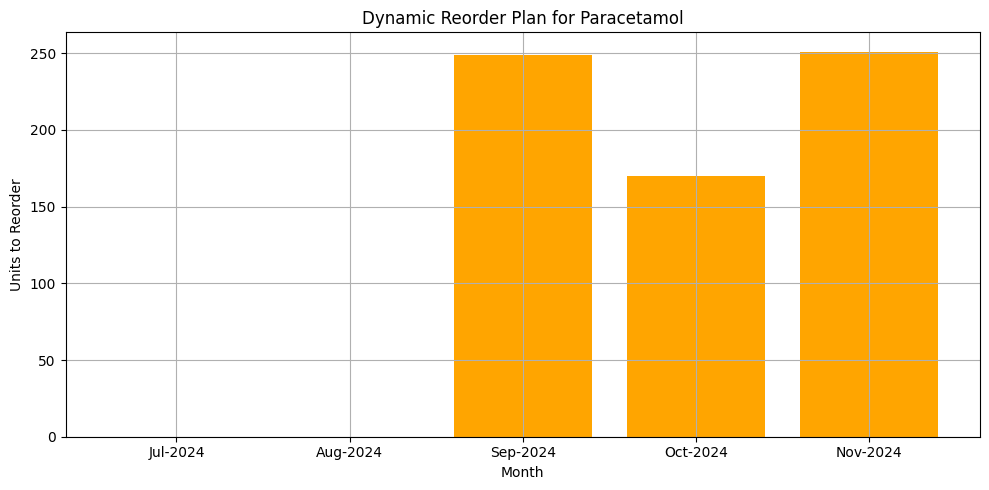

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(future_forecast["ds"].dt.strftime('%b-%Y'), future_forecast["reorder_quantity"], color='orange')
plt.title("Dynamic Reorder Plan for Paracetamol")
plt.xlabel("Month")
plt.ylabel("Units to Reorder")
plt.grid(True)
plt.tight_layout()
plt.show()
